In [61]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

In [62]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [63]:
# # Data Cleaning
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})

# train['Age'] = train['Age'].fillna(round(train['Age'].mean()))
# test['Age'] = test['Age'].fillna(round(test['Age'].mean()))
# test['Fare'] = test['Fare'].fillna(round(test['Fare'].mean()))

columns_to_drop = ["PassengerId", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)


In [64]:
class RoundingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        X = X.round() 
        return X
    
imputer = SimpleImputer(strategy='mean')
rounder = RoundingTransformer()
preprocessing_pipeline = Pipeline([
    ('imputer', imputer),
    ('rounder', rounder)
])

# Create the scaler
scaler = MinMaxScaler()

# Create the logistic regression model
lr_model = LogisticRegression(C=100, penalty='l2')

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('scaler', MinMaxScaler()),
    ('lr', lr_model)
])

In [65]:
# Assign Features and Labels
X_train = train[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
# X_train = train[["Pclass", "Age", "Fare", "Sex_binary"]]
y_train = train["Survived"]
X_test = test[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
# X_test = test[["Pclass", "Age", "Fare", "Sex_binary"]]
y_test = gender_submission["Survived"]

In [66]:
# # Fit the pipeline to your training data 
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

In [67]:

accuracy = accuracy_score(y_test, predictions)
accuracy

0.9425837320574163

[0.78888889 0.78651685 0.74157303 0.82022472 0.80898876 0.76404494
 0.79775281 0.7752809  0.79775281 0.80898876]


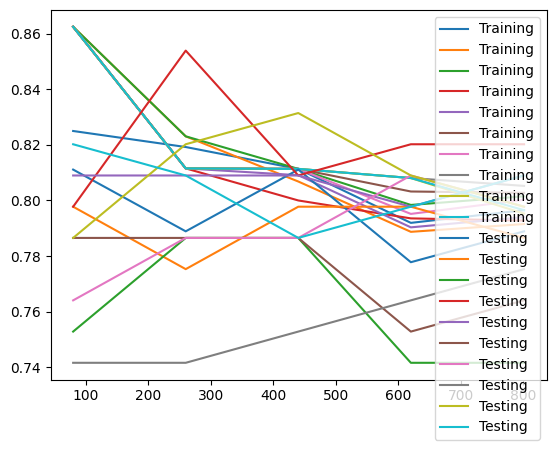

In [68]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
import matplotlib.pyplot as plt

# Cross-Validation Curve
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(cv_scores)  # Example output

# Learning Curve 
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=10)
plt.plot(train_sizes, train_scores, label='Training')
plt.plot(train_sizes, test_scores, label='Testing')
plt.legend()
plt.show()


In [69]:
# Hyperparameter Grid (adjust as needed)
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 110, 125, 150, 200],
    'lr__C': np.logspace(-3, 2, num=10),
    'lr__solver': ['liblinear', 'saga'],
    'lr__class_weight': [None, 'balanced']
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10)
grid_search.fit(X_train, y_train)
# print(grid_search.best_params_) 

best_model = grid_search.best_estimator_
# best_model.steps[-1][1].solver = 'liblinear'  # Or 'saga' 
best_model.steps[-1][1].solver = 'saga'  # Or 'liblinear' 

# RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=20) 
random_search.fit(X_train, y_train)
# print(random_search.best_params_)

# BayesSearchCV
bayes_search = BayesSearchCV(pipeline, param_grid, cv=5) 
bayes_search.fit(X_train, y_train) 
# print(bayes_search.best_params_) 


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing',
                                         Pipeline(steps=[('imputer',
                                                          SimpleImputer()),
                                                         ('rounder',
                                                          RoundingTransformer())])),
                                        ('scaler', MinMaxScaler()),
                                        ('lr', LogisticRegression(C=100))]),
              search_spaces={'lr__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                             'lr__class_weight': [None, 'balanced'],
                             'lr__penalty': ['l1', 'l2'],
                             'lr__solver': ['liblinear', 'saga']})

In [70]:
print(f"grid_search.best_params_: {grid_search.best_params_}") 
print(f"random_search.best_params_: {random_search.best_params_}")
print(f"bayes_search.best_params_: {bayes_search.best_params_}") 

print(f"Grid Search best score: {grid_search.best_score_}")
print(f"Random Search best score: {random_search.best_score_}")
print(f"Bayes Search best score: {bayes_search.best_score_}")

best_params = {'C': 0.5994842503189409, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


grid_search.best_params_: {'lr__C': 0.5994842503189409, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
random_search.best_params_: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__class_weight': None, 'lr__C': 0.5994842503189409}
bayes_search.best_params_: OrderedDict({'lr__C': 0.5994842503189409, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'})
Grid Search best score: 0.7968414481897628
Random Search best score: 0.7912497646098802
Bayes Search best score: 0.7912497646098802


In [71]:
# model = LogisticRegression(**best_params) 
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('scaler', MinMaxScaler()),
    ('lr', LogisticRegression(**best_params) )
])

# # Fit the pipeline to your training data 
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Pipeline model accuracy: {accuracy}")

Pipeline model accuracy: 0.9784688995215312


In [72]:
# from hyperopt import fmin, tpe, hp

# # Define the objective function (example)
# def objective(params):
#     pipeline.set_params(**params)  
#     return -np.mean(cross_val_score(pipeline, X_train, y_train, cv=5)) 

# # Define the search space 
# space = {
#     'lr__penalty': hp.choice('lr__penalty', ['l2']),
#     'lr__C': hp.uniform('lr__C', 0.001, 10)
# }

# # Run TPE optimization
# best = fmin(objective, space, algo=tpe.suggest, max_evals=50) 


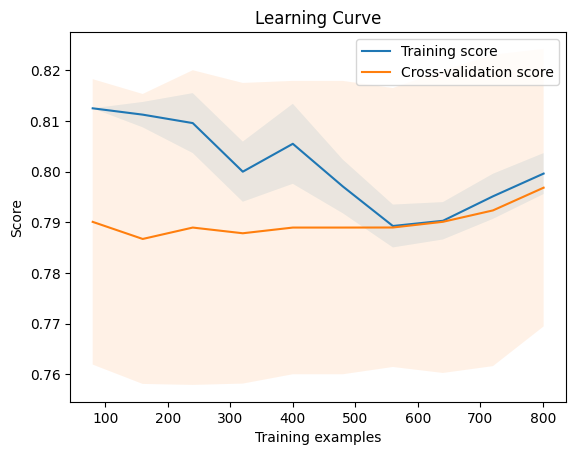

In [73]:
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=10, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate means and standard deviations for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()


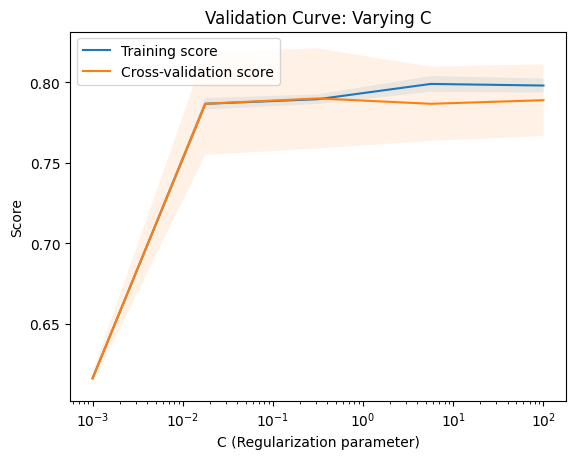

In [74]:
param_name = 'lr__C'  # Choose a hyperparameter to vary
param_range = np.logspace(-3, 2, num=5)

train_scores, test_scores = validation_curve(
    pipeline, X_train, y_train, param_name=param_name, param_range=param_range, cv=10)

# Calculate means and standard deviations 
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label='Training score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(param_range, test_mean, label='Cross-validation score')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Validation Curve: Varying C")
plt.xlabel("C (Regularization parameter)")
plt.ylabel("Score")
plt.legend()
plt.xscale('log') 
plt.show()


In [76]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)


print(f"Accuracy Score: {accuracy:.4f} ± {cv_std:.4f}")

Accuracy Score: 0.9785 ± 0.0274


In [77]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_binary
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


C:\Users\Domenick Dobbs\AppData\Local\Temp\ipykernel_91836\2871391997.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Age'].fillna(value = round(train['Age'].mean()), inplace = True)
C:\Users\Domenick Dobbs\AppData\Local\Temp\ipykernel_91836\2871391997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age'].fillna(value

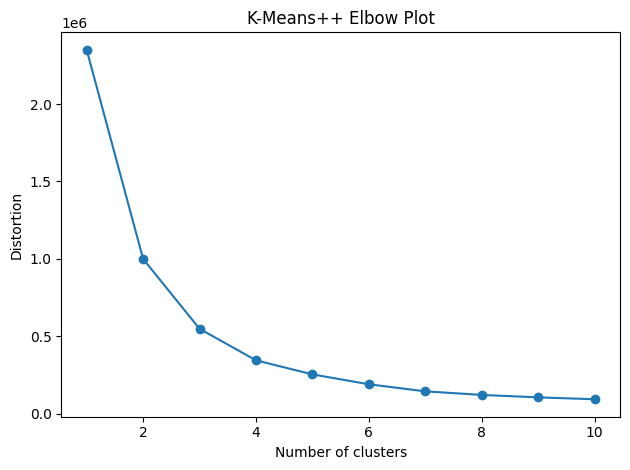

In [78]:
from sklearn.cluster import KMeans

X_train['Age'].fillna(value = round(train['Age'].mean()), inplace = True)
preprocessing_pipeline.fit(X_train)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300,
                random_state=0)
    km.fit(X_train)
    distortions.append(km.inertia_)




    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("K-Means++ Elbow Plot")
plt.tight_layout()
plt.show()    

In [ ]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters=2)
labels = ac.fit_predict(X_train)
# print(f'Cluster labels: {labels}')

In [ ]:
# f, ax2 = plt.subplots(figsize=(8, 3))
# y_ac = ac.fit_predict(X_train)
# ax2.scatter(X_train[y_ac == 0, 0], X_train[y_ac == 0, 1], c='lightblue',
#             edgecolor='black',
#             marker='o', s=40, label='Cluster 1')
# ax2.scatter(X_train[y_ac == 1, 0], X_train[y_ac == 1, 1], c='red',
#             edgecolor='black',
#             marker='s', s=40, label='Cluster 2')
# ax2.set_title('Agglomerative clustering')

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

features = train[['Age', 'Fare', 'Pclass']]
# features['Age'].fillna(value = round(train['Age'].mean()), inplace = True)

features = features.dropna()

scaler = StandardScaler()
features = scaler.fit_transform(features)
# Apply DBSCAN
db = DBSCAN()
labels = db.fit_predict(features)

# Plot results (if reduced to 2D using PCA or similar)
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.title("DBSCAN with Default Parameters") 
plt.show()